In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import plotly.express as px
import plotly.io as pio
import matplotlib.ticker as ticker
import seaborn as sns

from pykalman import KalmanFilter

In [2]:
yield_factors = pd.read_csv('../Github/Data/Processed/yield_usage.csv', header=[0], index_col=[0], parse_dates=True)
macro_df = pd.read_csv('../Github/Data/calculated_macro.csv', header=[0], index_col=[0], parse_dates=True)
ffr_df = pd.read_csv('../Github/Data/Raw Data/US FFR.csv', header=[0], index_col=[0], parse_dates=True).sort_index()

macro_df = macro_df.drop('Traditional Taylor Rule', axis = 1)

start_date = pd.to_datetime('1989-01-01')
macro_df = macro_df[start_date: ]
macro_df.columns = ['PCE', 'RGAP', 'FFR']
ffr_df = ffr_df[start_date: ]

In [3]:
yield_data_0 = yield_factors[pd.to_datetime('1990-01-02'): pd.to_datetime('1990-03-29')]
macro_0 = macro_df.loc[pd.to_datetime('1989-10-01'), :].values.tolist()[:2]

In [12]:
result_df_list = []

for i in range(len(ffr_df.index) - 1):
    start_date = ffr_df.index[i]
    end_date = ffr_df.index[i + 1] - pd.Timedelta(days = 1)

    yield_data = yield_factors.loc[start_date:end_date, ['Level', 'Slope', 'Curvature']]

    result_df_list.append(yield_data)
result_df_list = result_df_list[3:]

In [5]:
initial_state = np.array(yield_data_0.iloc[0, 0])

transition_matrix = np.array([[1]])

observations = yield_data_0[['Level']].values.reshape(61, 1)

observation_covariance = np.eye(1) * 0.3

observation_matrix = np.eye(1)

transition_covariance = np.array([[0.01]])

initial_state_covariance = np.eye(1) * 0.3

kf = KalmanFilter(
    initial_state_mean=initial_state,
    initial_state_covariance=initial_state_covariance,
    observation_covariance=observation_covariance,
    transition_covariance=transition_covariance,
    observation_matrices=observation_matrix,
    transition_matrices=transition_matrix
)

(filtered_state_means, _) = kf.filter(observations)

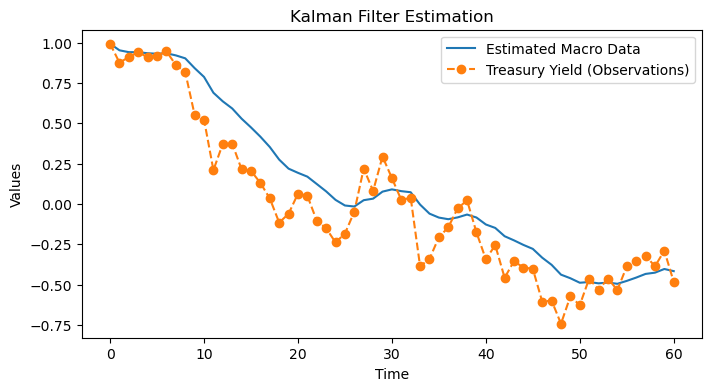

In [7]:
plt.figure(figsize=(8, 4))
plt.plot(filtered_state_means[:, 0], label='Estimated Macro Data')
plt.plot(observations, label='Treasury Yield (Observations)', linestyle='dashed', marker='o')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Kalman Filter Estimation')
plt.show()

In [10]:
filtered_state_means[-1][0]

-0.416670784881525

In [15]:
np.random.seed(4200)
all_factors = []
for df in result_df_list:
    factors = []
    n_components_per_state = 3
    n_hidden_states = 1

    for name in ['Level', 'Slope', 'Curvature']:

        initial_state = np.array(df[name][0])
        transition_matrix = np.array([[1]])

        observations = df[[name]].values.reshape(-1, 1)
        observation_covariance = np.eye(1) * 0.3
        observation_matrix = np.eye(1)

        transition_covariance = np.array([[0.01]])

        initial_state_covariance = np.eye(1) * 0.3

        kf = KalmanFilter(
            initial_state_mean=initial_state,
            initial_state_covariance=initial_state_covariance,
            observation_covariance=observation_covariance,
            transition_covariance=transition_covariance,
            observation_matrices=observation_matrix,
            transition_matrices=transition_matrix
        )

        (filtered_state_means, _) = kf.filter(observations)

        factors.append(filtered_state_means[-1][0])
    all_factors.append(factors)

In [16]:
all_factors = np.array(all_factors)
idx_another = macro_df.index[3:]
idx_another = idx_another[: -2]

all_factors = pd.DataFrame(all_factors, index = idx_another, columns = ['Level', 'Slope', 'Curvature'])

In [17]:
new_macro = pd.concat([macro_df, all_factors], axis = 1).dropna(how = 'any')
new_macro = new_macro.drop('FFR', axis = 1)
new_macro.to_csv('../Github/Data/Processed/New_Macro_Kalman.csv')